# MarlimR3D Model using `emg3d`

### Note regarding runtime

The following environment variables were set before starting Jupyter:
```
export OMP_NUM_THREADS=1
export MKL_NUM_THREADS=1
export OPENBLAS_NUM_THREADS=1
```
This ensures that our code runs only on one thread. CPU-time is therefore the same as walltime (or even a tiny fraction smaller).

In [1]:
import emg3d
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
%load_ext memory_profiler

In [2]:
%matplotlib notebook

## Load model

In [3]:
data = np.load('../marlim_comp.npz')  #  or 'marlim_orig.npz'
tres_h = data['res_h']
tres_v = data['res_v']

# We have to add an air layer
hz = np.r_[data['hz'], 20]

mesh_orig = emg3d.TensorMesh(
    [data['hx'], data['hy'], hz], x0=data['x0'])

# Add air resistivity
res_h_orig = 1e8*np.ones(mesh_orig.vnC)
res_v_orig = 1e8*np.ones(mesh_orig.vnC)
res_h_orig[:, :, :-1] = tres_h
res_v_orig[:, :, :-1] = tres_v

mesh_orig

TensorMesh: 90,172,895 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    515    364,325.00    415,825.00    100.00    100.00    1.00
   y    563  7,490,049.00  7,546,349.00    100.00    100.00    1.00
   z    311     -6,200.00         20.00     20.00     20.00    1.00

<IPython.core.display.Javascript object>


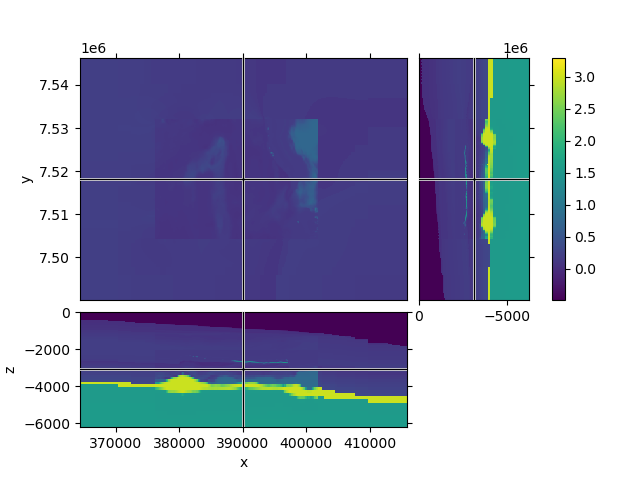

In [4]:
# Create model instance
model_orig = emg3d.Model(mesh_orig, property_x=res_h_orig, property_z=res_v_orig, mapping='Resistivity')

del data, tres_h, tres_v, res_h_orig, res_v_orig

# QC resistivities
mesh_orig.plot_3d_slicer(np.log10(model_orig.property_x), clim=[np.log10(0.32), np.log10(2000)])

# QC anisotropies
# mesh_orig.plot_3d_slicer(np.sqrt(model_orig.property_z/model_orig.property_x))

## Load survey

In [5]:
ds = xr.load_dataset('../marlim_survey.nc', engine='h5netcdf')
# data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')

### Extract required info

In [6]:
# Use reciprocity: rec becomes src
src = [ds.rec_x, ds.rec_y, ds.rec_z,
       ds.rec_theta, ds.rec_dip]

# Use reciprocity: src becomes rec
rec_x = ds.data_il.src_x[::2]
rec_y_il = ds.data_il.src_y
rec_z_il = ds.data_il.src_z

# Ensure same coordinates
print(np.allclose(rec_x, ds.data_bs.src_x[::2]))

rec_y_bs = ds.data_bs.src_y
rec_z_bs = ds.data_bs.src_z

# Frequency
freqs = ds.freqs.values

True


## Computation mesh

In [7]:
# Get cell widths and origin in each direction
inp = {'freq': freqs.min(), 'max_domain': 50000}
minres = model_orig.property_x.min()
maxres = model_orig.property_z[model_orig.property_z<1e7].max()

xdomain = [src[0]-5000, src[0]+5000]
ydomain = [src[1]-3250, src[1]+2100]
zdomain = [-3100, 0]

xx, x0 = emg3d.meshes.get_hx_h0(  # -50 align with inp mesh
    res=[minres, maxres], fixed=src[0]-50, domain=xdomain,
    min_width=mesh_orig.hx[0], **inp)

yy, y0 = emg3d.meshes.get_hx_h0(  # -63 align with inp mesh
    res=[minres, maxres], fixed=src[1]-63, domain=ydomain,
    min_width=mesh_orig.hy[0], **inp)

zz, z0 = emg3d.meshes.get_hx_h0(
    res=[minres, 100, maxres], domain=zdomain,
    min_width=mesh_orig.hz[0], **inp)

# Create a TensorMesh instance.
mesh = emg3d.TensorMesh([xx, yy, zz], x0=[x0, y0, z0])
mesh

   Skin depth (m/l-r)  [m] : 805 / 56616
   Survey domain       [m] : 385275 - 395275
   Computation domain  [m] : 340225 - 440225
   Final extent        [m] : 338727 - 463824
   Min/max cell width  [m] : 100 / 100 / 22001
   Alpha survey/comp       : 1.000 / 1.470
   Number of cells (s/c/r) : 128 (101/26/1)

   Skin depth (m/l-r)  [m] : 805 / 56616
   Survey domain       [m] : 7514562 - 7519912
   Computation domain  [m] : 7467749 - 7567749
   Final extent        [m] : 7464458 - 7570040
   Min/max cell width  [m] : 100 / 100 / 16346
   Alpha survey/comp       : 1.000 / 1.480
   Number of cells (s/c/r) : 80 (54/26/0)

   Skin depth (m/l/r)  [m] : 805 / 14235 / 56616
   Survey domain       [m] : -3100 - 0
   Computation domain  [m] : -50000 - 50000
   Final extent        [m] : -54774 - 51694
   Min/max cell width  [m] : 20 / 20 / 16057
   Alpha survey/comp       : 1.000 / 1.450
   Number of cells (s/c/r) : 192 (156/36/0)



TensorMesh: 1,966,080 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128    338,727.10    463,823.91    100.00 22,001.01    1.47
   y     80  7,464,458.23  7,570,039.77    100.00 16,345.65    1.48
   z    192    -54,773.54     51,693.54     20.00 16,056.62    1.45

In [8]:
for domain, cc in zip([xdomain, ydomain, zdomain], ['x', 'y', 'z']):
    a = getattr(mesh_orig, 'vectorCC'+cc)[(getattr(mesh_orig, 'vectorCC'+cc) > domain[0]) * (getattr(mesh_orig, 'vectorCC'+cc) < domain[1])]
    b = getattr(mesh, 'vectorCC'+cc)[(getattr(mesh, 'vectorCC'+cc) > domain[0]) * (getattr(mesh, 'vectorCC'+cc) < domain[1])]
    print(f"{cc} :: {np.allclose(b, a, atol=0, rtol=1e-10)} - sum(diff): {sum(abs(a)-abs(b)):.2f}")

x :: True - sum(diff): 0.00
y :: True - sum(diff): 0.00
z :: True - sum(diff): -0.00


In [9]:
# Interpolate to computational mesh
model = model_orig.interpolate2grid(mesh_orig, mesh, method='volume', log=True)

del mesh_orig, model_orig

# `emg3d` computation

In [10]:
solver_params = {'linerelaxation': True, 'semicoarsening': True,
                 'verb': -1, 'return_info': True}

# Pre-allocate results-array
egd = np.zeros((2, rec_x.size, 6, 6), dtype=complex)
    
max_mem = 0
tot_time = 0
results = {}
for ii, freq in enumerate(freqs):
    print(f"\n === Frequency {ii+1}/{freqs.size} :: {freq} Hz ===")
    # Source field
    sfield = emg3d.fields.get_source_field(mesh, src, freq, strength=0)
   
    mem = %memit -o efield, info = emg3d.solve(mesh, model, sfield, **solver_params)
    tot_time += info['time']
    ram = (mem.mem_usage[0] - mem.baseline)/1024
    if ram > max_mem:
        max_mem = ram
    
    # Save full field after each iteration
    # (if something aborts the loop the previous are still on disk)
    results[str(freq)] = efield
    emg3d.save('fullfields.h5', results=results, mesh=mesh, verb=0)
 
    # Get h-field
    hfield = emg3d.fields.get_h_field(mesh, model, efield)
    
    # Extract (interpolate) fields at receiver locations from the emg3d result.
    for i, rec in enumerate(zip([rec_y_il, rec_y_bs], [rec_z_il, rec_z_bs])):
        # Electric fields
        egd[i, :, ii, 0] = emg3d.fields.get_receiver(mesh, efield.fx, (rec_x, rec[0], rec[1]))  # Ex
        egd[i, :, ii, 1] = emg3d.fields.get_receiver(mesh, efield.fy, (rec_x, rec[0], rec[1]))  # Ey
        egd[i, :, ii, 2] = emg3d.fields.get_receiver(mesh, efield.fz, (rec_x, rec[0], rec[1]))  # Ez
        # Magnetic fields
        egd[i, :, ii, 3] = emg3d.fields.get_receiver(mesh, hfield.fx, (rec_x, rec[0], rec[1]))  # Hx
        egd[i, :, ii, 4] = emg3d.fields.get_receiver(mesh, hfield.fy, (rec_x, rec[0], rec[1]))  # Hy
        egd[i, :, ii, 5] = emg3d.fields.get_receiver(mesh, hfield.fz, (rec_x, rec[0], rec[1]))  # Hz

time = f"{tot_time:.0f} s"
ram = f"{max_mem:.3f} GiB"
print(f"\ntime: {time}; memory usage: {ram}")


 === Frequency 1/6 :: 0.125 Hz ===
:: emg3d :: 9.6e-07; 10; 0:05:04; CONVERGED
peak memory: 1643.52 MiB, increment: 553.17 MiB

 === Frequency 2/6 :: 0.25 Hz ===
:: emg3d :: 3.1e-07; 10; 0:04:58; CONVERGED
peak memory: 1813.56 MiB, increment: 489.69 MiB

 === Frequency 3/6 :: 0.5 Hz ===
:: emg3d :: 7.8e-07; 7; 0:03:28; CONVERGED
peak memory: 1877.03 MiB, increment: 463.44 MiB

 === Frequency 4/6 :: 0.75 Hz ===
:: emg3d :: 2.1e-07; 7; 0:03:29; CONVERGED
peak memory: 1941.16 MiB, increment: 435.91 MiB

 === Frequency 5/6 :: 1.0 Hz ===
:: emg3d :: 6.7e-07; 6; 0:02:57; CONVERGED
peak memory: 2096.43 MiB, increment: 499.65 MiB

 === Frequency 6/6 :: 1.25 Hz ===
:: emg3d :: 7.9e-07; 5; 0:02:32; CONVERGED
peak memory: 2145.20 MiB, increment: 456.88 MiB

time: 1348 s; memory usage: 0.540 GiB


In [11]:
# Save the two lines
ds.data_il.data[::2, :, :] = egd[0, :, :, :].real  # Inline RE
ds.data_il.data[1::2, :, :] = egd[0, :, :, :].imag  # Inline IM

ds.data_bs.data[::2, :, :] = egd[1, :, :, :].real  # Broadside RE
ds.data_bs.data[1::2, :, :] = egd[1, :, :, :].imag  # Broadside IM

# Add info
ds.attrs['runtime'] = time
ds.attrs['n_procs'] = 1
ds.attrs['max_ram'] = ram
ds.attrs['n_cells'] = f"({mesh.nCx} x {mesh.nCy} x {mesh.nCz}) - {mesh.nC}"
ds.attrs['n_nodes'] = 'N/A'
ds.attrs['n_dof'] = 'N/A'
ds.attrs['extent'] = (f"x = {mesh.vectorNx[0]:.1f}-{mesh.vectorNx[-1]:.1f}; " # Total mesh extent
                      f"y = {mesh.vectorNy[0]:.1f}-{mesh.vectorNy[-1]:.1f}; "
                      f"z = {mesh.vectorNz[0]:.1f}-{mesh.vectorNz[-1]:.1f}")
ds.attrs['min_vol'] = f"{np.min(mesh.vol):.1f}"
ds.attrs['max_vol'] = f"{np.max(mesh.vol):.1f}"
ds.attrs['machine'] = "Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04"
ds.attrs['version'] = f"emg3d v{emg3d.__version__}"
ds.attrs['date'] = datetime.today().isoformat()

# ADD A NOTE that this is preliminary
ds.attrs['NOTE'] = 'Preliminary results, not final'

# Save it under <{model}_{code}.nc>
ds.to_netcdf(f"../results/marlim_emg3d.nc", engine='h5netcdf')
ds

<xarray.Dataset>
Dimensions:     (components: 6, freqs: 6, src_x: 408)
Coordinates:
  * components  (components) object 'Ex' 'Ey' 'Ez' 'Hx' 'Hy' 'Hz'
  * freqs       (freqs) float32 0.125 0.25 0.5 0.75 1.0 1.25
  * src_x       (src_x) float32 379375.0 379375.0 379475.0 ... 401175.0 401175.0
Data variables:
    data_bs     (src_x, freqs, components) float64 -1.028e-14 ... 3.663e-18
    data_il     (src_x, freqs, components) float64 -1.057e-14 ... 5.714e-17
Attributes:
    date:       2020-09-05T14:07:36.634099
    extent:     x = 338727.1-463823.9; y = 7464458.2-7570039.8; z = -54773.5-...
    machine:    Laptop; i7-6600U CPU@2.6 GHz x4; 16 GB of memory, Ubuntu 18.04
    max_ram:    0.540 GiB
    max_vol:    5774295730506.1
    min_vol:    200000.0
    n_cells:    (128 x 80 x 192) - 1966080
    n_dof:      N/A
    n_nodes:    N/A
    n_procs:    1
    rec_dip:    0.0
    rec_theta:  0.0
    rec_x:      390275.0
    rec_y:      7517812.0
    rec_z:      -849.7838
    runtime:    1348 s
    src_dip:    0.0
    src_theta:  0.0
    strength:   1.0
    version:    emg3d v0.12.0
    NOTE:       Preliminary results, not final

## Figure 4 from Correa and Menezes (2019), but noise-free data

In [12]:
data = xr.load_dataset('../marlim_data.nc', engine='h5netcdf')

<IPython.core.display.Javascript object>


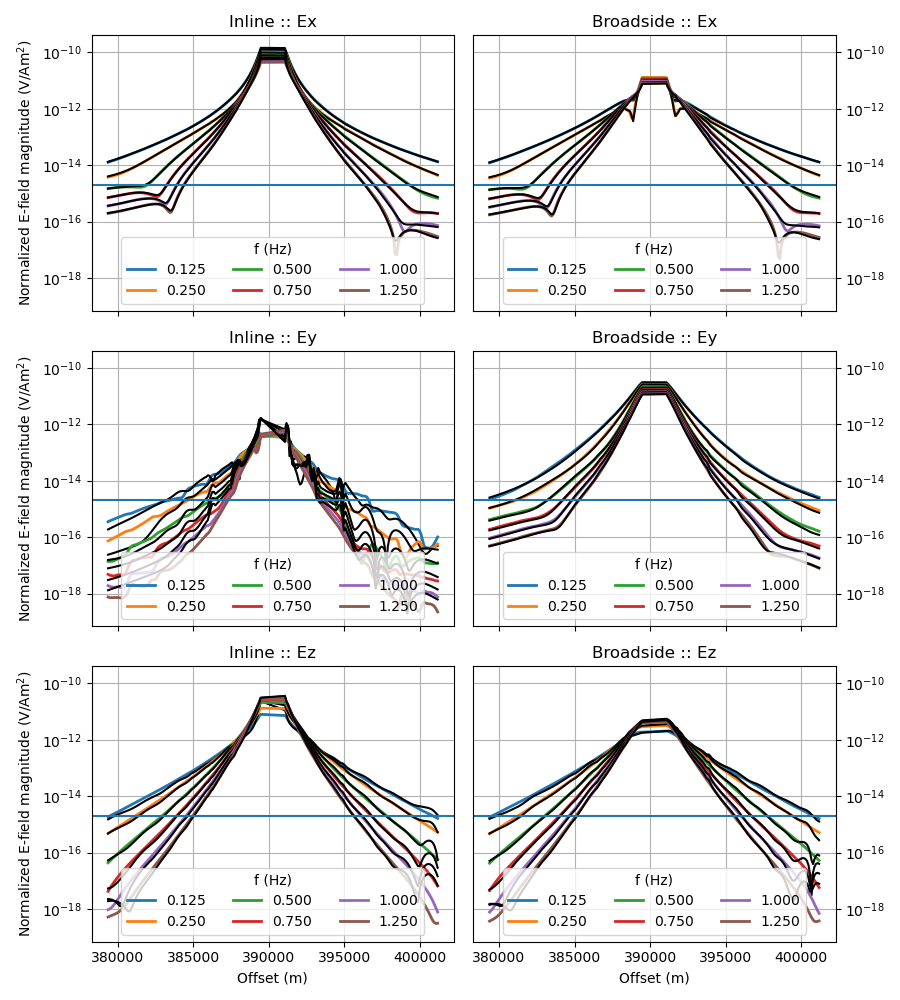

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(9, 10), sharex=True, sharey=True)

# Loop over Inline/Broadside
for iii, datname in enumerate(['data_il', 'data_bs']):

    # Take absolute value
    tdat = np.abs(getattr(data, datname).data[::2, :, :] +
                  1j*getattr(data, datname).data[1::2, :, :])

    # Loop over components Ex, Ey, Ez
    for ii, comp in enumerate(data.components.values[:3]):

        plt.sca(axs[ii, iii])
        plt.title(f"{['Inline', 'Broadside'][iii]} :: {comp}")

        # Loop over frequencies
        for i, freq in enumerate(data.freqs.values):

            # Plot this component/frequency
            plt.plot(rec_x, tdat[:, i, ii], f"C{i}", lw=2, label=f"{freq:4.3f}")
            plt.plot(rec_x, abs(egd[iii, :, i, ii]), 'k-')

        plt.axhline(2e-15)
        plt.legend(title='f (Hz)', loc='lower center', ncol=3)
        plt.grid('on')
        plt.yscale('log')
        
        if ii == 2:
            plt.xlabel('Offset (m)')
        if iii == 0:
            plt.ylabel('Normalized E-field magnitude (V/Am$^2$)')
        else:
            axs[ii, iii].yaxis.set_ticks_position('right')
            axs[ii, iii].yaxis.set_label_position('right')

plt.tight_layout()
plt.show()

In [14]:
emg3d.Report()

--------------------------------------------------------------------------------
  Date: Sat Sep 05 14:07:38 2020 CEST

                OS : Linux
            CPU(s) : 4
           Machine : x86_64
      Architecture : 64bit
               RAM : 15.5 GB
       Environment : Jupyter

  Python 3.8.5 | packaged by conda-forge | (default, Aug 29 2020, 01:22:49)
  [GCC 7.5.0]

             numpy : 1.19.1
             scipy : 1.5.2
             numba : 0.51.2
             emg3d : 0.12.0
           empymod : 2.0.2
            xarray : 0.16.0
        discretize : 0.5.0
              h5py : 2.10.0
        matplotlib : 3.3.1
           IPython : 7.18.1
--------------------------------------------------------------------------------